# Bias quantification in the 14th and 15th legislatures

In this notebook, we will compute the WEAT bias metrics for word2vec models (CBOW and Skip-Gram) with embeddings dimension 200 and 500 trained on deputies questions during the 14th and 15th French legislatures.


## <a id="content">Contents</a>
1. [Identification of the grammatical gender direction using LDA](#grammatical)
2. [Gender bias measurement](#gender-bias-measurement)
   - [Preliminaries on permutation statistical test](#permutation-test)
   - [WEAT tests](#weat)
3. [Conclusion](#conclusion)
4. [References](#references)

<ins>*Loading useful libraries*</ins>

In [1]:
import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

import os 
os.chdir("../lib/")
from utils import *
os.chdir("../notebooks/")

<ins>*Loading pre-trained word2vec models*</ins>

In [2]:
# load models of the 14th legislature 
cbow_XIV_200 = gensim.models.Word2Vec.load('../../cbow_XIV/w2v_cbow_200D_fth_cleaned').wv
cbow_XIV_500 = gensim.models.Word2Vec.load('../../cbow_XIV/w2v_cbow_500D_fth_cleaned').wv
sg_XIV_200 = gensim.models.Word2Vec.load('../../sg_XIV/w2v_sg_200D_fth_cleaned').wv
sg_XIV_500 = gensim.models.Word2Vec.load('../../sg_XIV/w2v_sg_500D_fth_cleaned').wv

# load models of the 15th legislature 
cbow_XV_200 = gensim.models.Word2Vec.load('../../cbow_XV/w2v_cbow_200D_fth_cleaned').wv
cbow_XV_500 = gensim.models.Word2Vec.load('../../cbow_XV/w2v_cbow_500D_fth_cleaned').wv
sg_XV_200 = gensim.models.Word2Vec.load('../../sg_XV/w2v_sg_200D_fth_cleaned').wv
sg_XV_500 = gensim.models.Word2Vec.load('../../sg_XV/w2v_sg_500D_fth_cleaned').wv



## <a id="grammatical">1. Identification of the grammatical gender direction using LDA </a> ([&uarr;](#content))


Before performing any bias measurements, we should first disentangle the grammatical gender direction.
For this, we use the iterative method proposed by [Sabbaghi et al.](https://arxiv.org/pdf/2206.01691.pdf). It consists of iteratively extracting the grammatical gender direction from the new word embedding (from which the grammatical component is removed) until we reach an classification accuracy $^{\star}$ of $\approx 50\%$. The iteratively extracted grammatical gender directions are saved to be used later in removing the grammatical gender component from word embeddings. 

$^{\star}$ The classification task consist of using LDA to distinguish between grammatically feminine and grammatically masculine words.

In [3]:
# loading grammatical gender word lists
with open("../data/grammatical_masculine.txt", "r") as output:
    masc_gram = output.read()
    output.close()

with open("../data/grammatical_feminine.txt", "r") as output:
    fem_gram = output.read()
    output.close()

# grammatically feminine and masculine words
fem_gram = fem_gram.split('\n')
masc_gram = masc_gram.split('\n')

# final lists of grammatically gendered words
final_gram_fem, final_gram_masc = [], []
for word in fem_gram:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        final_gram_fem.append(word)

for word in masc_gram:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        final_gram_masc.append(word)
print(len(final_gram_fem), len(final_gram_masc))


# keep the same size for both lists
n_words = min(len(final_gram_fem), len(final_gram_masc))
final_gram_fem, final_gram_masc = final_gram_fem[:n_words], final_gram_masc[:n_words]
print(len(final_gram_fem), len(final_gram_masc))

896 963
896 896


In [10]:
with open("../data/grammatical_feminine_final_used.txt", "w") as output:
        for row in final_gram_fem:
            output.write(str(row) + '\n')
        #output.write(str(fem_gram))
        output.close()

with open("../data/grammatical_masc_final_used.txt", "w") as output:
        for row in final_gram_masc:
            output.write(str(row) + '\n')
        #output.write(str(fem_gram))
        output.close()

<ins>*Get the principal grammatical gender direction using LDA*</ins>

`gram_dirct` function from `lib/utils.py` returns the iterative grammatical gender directions as well as the classification test scores that reflect how much more grammatical signals are still hidden in the word embeddings. 

The successive grammatical gender directions will later be used to disentangle the grammatical signals from embeddings. 

**Note:** The iterative disentanglement proces can take some time to converge (1 to 2 minutes).

In [4]:
# iterative extraction of the grammatical gender direction 
# leg XIV
test_score_cbow_XIV_200, gram_dir_cbow_XIV_200 = gram_dirct(cbow_XIV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_cbow_XIV_500, gram_dir_cbow_XIV_500 = gram_dirct(cbow_XIV_500, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XIV_200, gram_dir_sg_XIV_200 = gram_dirct(sg_XIV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XIV_500, gram_dir_sg_XIV_500 = gram_dirct(sg_XIV_500, final_gram_masc, final_gram_fem, test_size=.2)

# leg XV
test_score_cbow_XV_200, gram_dir_cbow_XV_200 = gram_dirct(cbow_XV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_cbow_XV_500, gram_dir_cbow_XV_500 = gram_dirct(cbow_XV_500, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XV_200, gram_dir_sg_XV_200 = gram_dirct(sg_XV_200, final_gram_masc, final_gram_fem, test_size=.2)
test_score_sg_XV_500, gram_dir_sg_XV_500 = gram_dirct(sg_XV_500, final_gram_masc, final_gram_fem, test_size=.2)


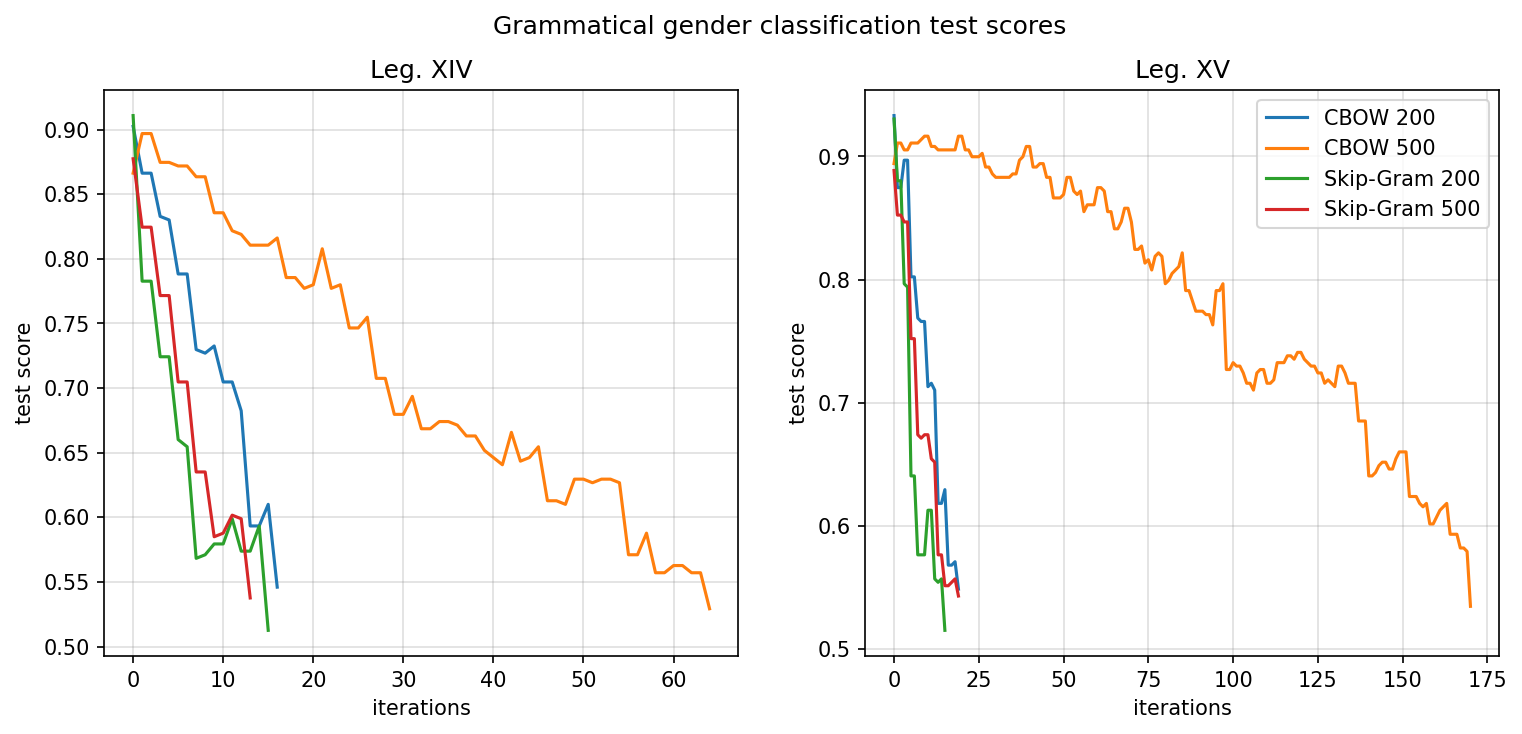

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(test_score_cbow_XIV_200, label='CBOW 200')
axes[0].plot(test_score_cbow_XIV_500, label='CBOW 500')
axes[0].plot(test_score_sg_XIV_200, label='Skip-Gram 200')
axes[0].plot(test_score_sg_XIV_500, label='Skip-Gram 500')
axes[0].set_title('Leg. XIV')
axes[0].set_xlabel('iterations')
axes[0].set_ylabel('test score')
axes[0].grid(color='gray', linestyle='-', linewidth=.2)

axes[1].plot(test_score_cbow_XV_200, label='CBOW 200')
axes[1].plot(test_score_cbow_XV_500, label='CBOW 500')
axes[1].plot(test_score_sg_XV_200, label='Skip-Gram 200')
axes[1].plot(test_score_sg_XV_500, label='Skip-Gram 500')
axes[1].set_title('Leg. XV')
axes[1].set_xlabel('iterations')
axes[1].set_ylabel('test score')

axes[1].grid(color='gray', linestyle='-', linewidth=.2)
plt.suptitle("Grammatical gender classification test scores")
plt.legend()
plt.show()

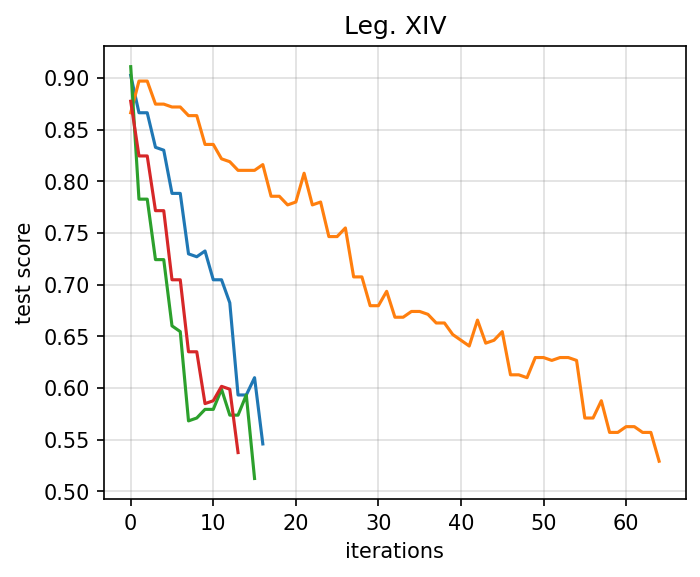

In [12]:
plt.figure(figsize=(5,4))
plt.plot(test_score_cbow_XIV_200, label='CBOW 200')
plt.plot(test_score_cbow_XIV_500, label='CBOW 500')
plt.plot(test_score_sg_XIV_200, label='Skip-Gram 200')
plt.plot(test_score_sg_XIV_500, label='Skip-Gram 500')
plt.title('Leg. XIV')
plt.xlabel('iterations')
plt.ylabel('test score')
plt.grid(color='gray', linestyle='-', linewidth=.2)
#plt.legend()
plt.savefig("../figures/grammatical_disen_XIV", dpi=300)

**Comment:**

We can see that extracting the grammatical gender direction only once is indeed not sufficient and it usually takes between 20 and 30 iterations to obtain satisfying results.

## <a id="gender-bias-measurement">2. Gender bias measurement</a> ([&uarr;](#content))


### <a id="permutation-test">2.1. Preliminaries on permutation statistical test</a> ([&uarr;](#content))


In this section, we present the framework of the permutation test statistic we will use to evaluate how some lists of words are more biased towards men or women. 

First off, we denote by:
* **A**: 1st attributes list: **men-definition words** {fils, père, frère, pères, monsieur, homme, masculin}
* **B**: 2nd attributes list: **women-definition words** {fille, mère, sœur, mères, madame, femme, féminin}

* **X**: 1st target words: e.g. **science**
* **Y**: 2nd target words: e.g. **arts**

*Note:* 
* During this test statistic, we will always make sure to have X and Y denote the lists of topic words that are likely to reflect the bias in the corpus. For instance, by taking *X=science* and *Y=arts*, the statistical test will evaluate how likely science is associated to men and arts to women that the other way around. 
* We will suffice ourselves of target lists of size max 6. Otherwise, computing the test p-value will take very long time.

The hypotheses of the permuation test are:
\begin{align*}
\begin{cases}
H_0:& \text{ No association} \\
H_1:& \text{ X is more associated to A (men) and Y to B (women) that the other way around}
\end{cases}
\end{align*}

We will use the associatation test statistic:
\begin{equation*}
S(X, Y, A, B) = \sum_{x\in X} S(x, A, B) - \sum_{y\in Y} S(y, A, B)
\end{equation*}

where 
\begin{equation*}
S(w, A, B) = mean_{a\in A} \cos(\vec{w}, \vec{a}) - mean_{b\in B} \cos(\vec{w}, \vec{b})
\end{equation*}

*Interpretation:* In the case where X=science, Y=arts, A=men, B=women, and w="science"
* if $S(w, A, B)>0$, it means that *science* is more biased towards *men* than *women*.
* if $S(X, Y, A, B)>0$, it means that *science* is more biased towards men and *arts* towards *women* than the other way round. 

Afterwards, to perform the test, we consider all the partitions $X_i, Y_i$ of $X\times Y$ of equal size and compute $S(X_i, Y_i, A, B)$. Then the p-value of this test statistic is 
\begin{equation*}
p-value = \mathcal{Pr}[S(X_i, Y_i, A, B) > S(X, Y, A, B)]
\end{equation*}

Finally, by setting a significance level of $\alpha =5\%$, we compare $\alpha$ to the p-value:
* A p-value less than or equal $\alpha$ is statistically significant (i.e. there is bias in the lists)
* A p-value higher than $\alpha$ is not statistically significant (i.e. we cannot really suppose any association).


In [13]:
# female and male definition words 
female_related_words = "fille mère soeur madame femme mme féminin".split()
male_related_words = "garçon père frère monsieur homme mr masculin".split()

<ins>*Female and male words embeddings **WITHOUT** disentanglement*</ins>

In [17]:
# female and male definition words emebddings <!-- WITHOUT --> disentanglement
no_disen_female_cbow_XIV_200, no_disen_male_cbow_XIV_200 = cbow_XIV_200[female_related_words], cbow_XIV_200[male_related_words]
no_disen_female_cbow_XIV_500, no_disen_male_cbow_XIV_500 = cbow_XIV_500[female_related_words], cbow_XIV_500[male_related_words]
no_disen_female_sg_XIV_200, no_disen_male_sg_XIV_200 = sg_XIV_200[female_related_words], sg_XIV_200[male_related_words]
no_disen_female_sg_XIV_500, no_disen_male_sg_XIV_500 = sg_XIV_500[female_related_words], sg_XIV_500[male_related_words]

no_disen_female_cbow_XV_200, no_disen_male_cbow_XV_200 = cbow_XV_200[female_related_words], cbow_XV_200[male_related_words]
no_disen_female_cbow_XV_500, no_disen_male_cbow_XV_500 = cbow_XV_500[female_related_words], cbow_XV_500[male_related_words]
no_disen_female_sg_XV_200, no_disen_male_sg_XV_200 = sg_XV_200[female_related_words], sg_XV_200[male_related_words]
no_disen_female_sg_XV_500, no_disen_male_sg_XV_500 = sg_XV_500[female_related_words], sg_XV_500[male_related_words]


<ins>*Female and male words embeddings **WITH** disentanglement*</ins>

In [18]:
# female and male definition words emebddings <!-- WITH --> disentanglement
disen_female_cbow_XIV_200, disen_male_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, female_related_words, gram_dir_cbow_XIV_200), disentangle_gram_dirct(cbow_XIV_200, male_related_words, gram_dir_cbow_XIV_200)
disen_female_cbow_XIV_500, disen_male_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, female_related_words, gram_dir_cbow_XIV_500), disentangle_gram_dirct(cbow_XIV_500, male_related_words, gram_dir_cbow_XIV_500)
disen_female_sg_XIV_200, disen_male_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, female_related_words, gram_dir_sg_XIV_200), disentangle_gram_dirct(sg_XIV_200, male_related_words, gram_dir_sg_XIV_200)
disen_female_sg_XIV_500, disen_male_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, female_related_words, gram_dir_sg_XIV_500), disentangle_gram_dirct(sg_XIV_500, male_related_words, gram_dir_sg_XIV_500)

disen_female_cbow_XV_200, disen_male_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, female_related_words, gram_dir_cbow_XV_200), disentangle_gram_dirct(cbow_XV_200, male_related_words, gram_dir_cbow_XV_200)
disen_female_cbow_XV_500, disen_male_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, female_related_words, gram_dir_cbow_XV_500), disentangle_gram_dirct(cbow_XV_500, male_related_words, gram_dir_cbow_XV_500)
disen_female_sg_XV_200, disen_male_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, female_related_words, gram_dir_sg_XV_200), disentangle_gram_dirct(sg_XV_200, male_related_words, gram_dir_sg_XV_200)
disen_female_sg_XV_500, disen_male_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, female_related_words, gram_dir_sg_XV_500), disentangle_gram_dirct(sg_XV_500, male_related_words, gram_dir_sg_XV_500)

### <a id="weat">2.2. WEAT tests</a> ([&uarr;](#content))

We will use the same WEAT tests as suggested by [Sabbaghi et al.](https://arxiv.org/pdf/2206.01691.pdf). For instance:
* men-science and women-arts
  * scientifique technologie physique chimie mathématiques astronaute médecin informatique mécanique
  * poésie art dessin dance musique litérature roman artiste théâtre peinture philosophie
* men-career and women-family 
  * gestion professionnel entreprise salaire affaires carrière
  * maison parents enfants famille mariage ménage
* men-weapons and women-musical instruments
  * missiles, pistolet, char, bombe, couteau, grenade
  * décoration, fleurs, parfum, bouquet, papillon, rose
* gender association with some adjectives 


For more safety, we also make sure that the chosen nouns are not all of the same grammatical gender. In fact, sciencific words are usually grammatically feminine.This should be taken into account to avoid skewed results.


In [129]:
science_list = "scientifique technologie physique mathématiques informatique calcul".split()
arts_list = "art musique littérature théâtre peinture lettres".split()
# littérature<-> philosophie

career_list = "business professionnel entreprise salaire affaires carrière".split()  # bureau
family_list = "maison parents enfants famille mariage ménage".split()

weapons_list = "missiles, pistolet, char, bombe, couteau, grenade".split(', ')
flowers_list = "décoration, fleurs, parfum, bouquet, papillon, rose".split(', ') # rose gastronomie, culture

#power_list = "résistance force puissance effort robuste muscles".split()
power_list = "résistance force puissance autorité robuste muscles".split()
soft_list = "beauté calme affection amour émotions sensible".split()
#soft_list = "doux calme affection amour émotions sensible".split()

fin_science, fin_arts = [], []
for word in science_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_science.append(word)

for word in arts_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_arts.append(word)

fin_career, fin_family = [], []
for word in career_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_career.append(word)

for word in family_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_family.append(word)

fin_weapons, fin_flowers = [], []
for word in weapons_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_weapons.append(word)

for word in flowers_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_flowers.append(word)


fin_power, fin_soft = [], []
for word in power_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_power.append(word)

for word in soft_list:
    if word in cbow_XIV_200.index_to_key and word in cbow_XIV_500.index_to_key and word in cbow_XV_200.index_to_key and word in cbow_XV_500.index_to_key and word in sg_XIV_200.index_to_key and word in sg_XIV_500.index_to_key and word in sg_XV_200.index_to_key and word in sg_XV_500.index_to_key:
        fin_soft.append(word)

print(fin_science)
print(fin_arts)
print(fin_career)
print(fin_family)
print(fin_weapons)
print(fin_flowers)
print(fin_power)
print(fin_soft)

['scientifique', 'technologie', 'physique', 'mathématiques', 'informatique', 'calcul']
['art', 'musique', 'littérature', 'théâtre', 'peinture', 'lettres']
['business', 'professionnel', 'entreprise', 'salaire', 'affaires', 'carrière']
['maison', 'parents', 'enfants', 'famille', 'mariage', 'ménage']
['missiles', 'pistolet', 'char', 'bombe', 'couteau', 'grenade']
['décoration', 'fleurs', 'parfum', 'bouquet', 'papillon', 'rose']
['résistance', 'force', 'puissance', 'autorité', 'robuste', 'muscles']
['beauté', 'calme', 'affection', 'amour', 'émotions', 'sensible']


<ins>*Target words' embeddings **WITHOUT** disentanglement*</ins>

In [130]:
# target words embeddings <!-- WITHOUT -->
# science - arts words
no_disen_science_cbow_XIV_200, no_disen_arts_cbow_XIV_200 = cbow_XIV_200[fin_science], cbow_XIV_200[fin_arts]
no_disen_science_cbow_XIV_500, no_disen_arts_cbow_XIV_500 = cbow_XIV_500[fin_science], cbow_XIV_500[fin_arts]
no_disen_science_sg_XIV_200, no_disen_arts_sg_XIV_200 = sg_XIV_200[fin_science], sg_XIV_200[fin_arts]
no_disen_science_sg_XIV_500, no_disen_arts_sg_XIV_500 = sg_XIV_500[fin_science], sg_XIV_500[fin_arts]

no_disen_science_cbow_XV_200, no_disen_arts_cbow_XV_200 = cbow_XV_200[fin_science], cbow_XV_200[fin_arts]
no_disen_science_cbow_XV_500, no_disen_arts_cbow_XV_500 = cbow_XV_500[fin_science], cbow_XV_500[fin_arts]
no_disen_science_sg_XV_200, no_disen_arts_sg_XV_200 = sg_XV_200[fin_science], sg_XV_200[fin_arts]
no_disen_science_sg_XV_500, no_disen_arts_sg_XV_500 = sg_XV_500[fin_science], sg_XV_500[fin_arts]


# career - family words
no_disen_career_cbow_XIV_200, no_disen_family_cbow_XIV_200 = cbow_XIV_200[fin_career], cbow_XIV_200[fin_family]
no_disen_career_cbow_XIV_500, no_disen_family_cbow_XIV_500 = cbow_XIV_500[fin_career], cbow_XIV_500[fin_family]
no_disen_career_sg_XIV_200, no_disen_family_sg_XIV_200 = sg_XIV_200[fin_career], sg_XIV_200[fin_family]
no_disen_career_sg_XIV_500, no_disen_family_sg_XIV_500 = sg_XIV_500[fin_career], sg_XIV_500[fin_family]

no_disen_career_cbow_XV_200, no_disen_family_cbow_XV_200 = cbow_XV_200[fin_career], cbow_XV_200[fin_family]
no_disen_career_cbow_XV_500, no_disen_family_cbow_XV_500 = cbow_XV_500[fin_career], cbow_XV_500[fin_family]
no_disen_career_sg_XV_200, no_disen_family_sg_XV_200 = sg_XV_200[fin_career], sg_XV_200[fin_family]
no_disen_career_sg_XV_500, no_disen_family_sg_XV_500 = sg_XV_500[fin_career], sg_XV_500[fin_family]


# weapons - flowers words
no_disen_weapons_cbow_XIV_200, no_disen_flowers_cbow_XIV_200 = cbow_XIV_200[fin_weapons], cbow_XIV_200[fin_flowers]
no_disen_weapons_cbow_XIV_500, no_disen_flowers_cbow_XIV_500 = cbow_XIV_500[fin_weapons], cbow_XIV_500[fin_flowers]
no_disen_weapons_sg_XIV_200, no_disen_flowers_sg_XIV_200 = sg_XIV_200[fin_weapons], sg_XIV_200[fin_flowers]
no_disen_weapons_sg_XIV_500, no_disen_flowers_sg_XIV_500 = sg_XIV_500[fin_weapons], sg_XIV_500[fin_flowers]

no_disen_weapons_cbow_XV_200, no_disen_flowers_cbow_XV_200 = cbow_XV_200[fin_weapons], cbow_XV_200[fin_flowers]
no_disen_weapons_cbow_XV_500, no_disen_flowers_cbow_XV_500 = cbow_XV_500[fin_weapons], cbow_XV_500[fin_flowers]
no_disen_weapons_sg_XV_200, no_disen_flowers_sg_XV_200 = sg_XV_200[fin_weapons], sg_XV_200[fin_flowers]
no_disen_weapons_sg_XV_500, no_disen_flowers_sg_XV_500 = sg_XV_500[fin_weapons], sg_XV_500[fin_flowers]


# power - soft words
no_disen_power_cbow_XIV_200, no_disen_soft_cbow_XIV_200 = cbow_XIV_200[fin_power], cbow_XIV_200[fin_soft]
no_disen_power_cbow_XIV_500, no_disen_soft_cbow_XIV_500 = cbow_XIV_500[fin_power], cbow_XIV_500[fin_soft]
no_disen_power_sg_XIV_200, no_disen_soft_sg_XIV_200 = sg_XIV_200[fin_power], sg_XIV_200[fin_soft]
no_disen_power_sg_XIV_500, no_disen_soft_sg_XIV_500 = sg_XIV_500[fin_power], sg_XIV_500[fin_soft]

no_disen_power_cbow_XV_200, no_disen_soft_cbow_XV_200 = cbow_XV_200[fin_power], cbow_XV_200[fin_soft]
no_disen_power_cbow_XV_500, no_disen_soft_cbow_XV_500 = cbow_XV_500[fin_power], cbow_XV_500[fin_soft]
no_disen_power_sg_XV_200, no_disen_soft_sg_XV_200 = sg_XV_200[fin_power], sg_XV_200[fin_soft]
no_disen_power_sg_XV_500, no_disen_soft_sg_XV_500 = sg_XV_500[fin_power], sg_XV_500[fin_soft]

<ins>*Target words embeddings **WITH** disentanglement*</ins>

In [131]:
# disentangle science words
disen_science_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_science, gram_dir_cbow_XIV_200)
disen_science_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_science, gram_dir_cbow_XIV_500)
disen_science_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_science, gram_dir_sg_XIV_200)
disen_science_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_science, gram_dir_sg_XIV_500)

disen_science_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_science, gram_dir_cbow_XV_200)
disen_science_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_science, gram_dir_cbow_XV_500)
disen_science_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_science, gram_dir_sg_XV_200)
disen_science_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_science, gram_dir_sg_XV_500)


# disentangle arts words
disen_arts_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_arts, gram_dir_cbow_XIV_200)
disen_arts_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_arts, gram_dir_cbow_XIV_500)
disen_arts_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_arts, gram_dir_sg_XIV_200)
disen_arts_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_arts, gram_dir_sg_XIV_500)

disen_arts_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_arts, gram_dir_cbow_XV_200)
disen_arts_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_arts, gram_dir_cbow_XV_500)
disen_arts_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_arts, gram_dir_sg_XV_200)
disen_arts_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_arts, gram_dir_sg_XV_500)


# disentangle career words
disen_career_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_career, gram_dir_cbow_XIV_200)
disen_career_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_career, gram_dir_cbow_XIV_500)
disen_career_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_career, gram_dir_sg_XIV_200)
disen_career_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_career, gram_dir_sg_XIV_500)

disen_career_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_career, gram_dir_cbow_XV_200)
disen_career_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_career, gram_dir_cbow_XV_500)
disen_career_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_career, gram_dir_sg_XV_200)
disen_career_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_career, gram_dir_sg_XV_500)


# disentangle family words
disen_family_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_family, gram_dir_cbow_XIV_200)
disen_family_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_family, gram_dir_cbow_XIV_500)
disen_family_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_family, gram_dir_sg_XIV_200)
disen_family_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_family, gram_dir_sg_XIV_500)

disen_family_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_family, gram_dir_cbow_XV_200)
disen_family_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_family, gram_dir_cbow_XV_500)
disen_family_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_family, gram_dir_sg_XV_200)
disen_family_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_family, gram_dir_sg_XV_500)


# disentangle career words
disen_weapons_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_weapons, gram_dir_cbow_XIV_200)
disen_weapons_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_weapons, gram_dir_cbow_XIV_500)
disen_weapons_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_weapons, gram_dir_sg_XIV_200)
disen_weapons_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_weapons, gram_dir_sg_XIV_500)

disen_weapons_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_weapons, gram_dir_cbow_XV_200)
disen_weapons_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_weapons, gram_dir_cbow_XV_500)
disen_weapons_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_weapons, gram_dir_sg_XV_200)
disen_weapons_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_weapons, gram_dir_sg_XV_500)


# disentangle family words
disen_flowers_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_flowers, gram_dir_cbow_XIV_200)
disen_flowers_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_flowers, gram_dir_cbow_XIV_500)
disen_flowers_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_flowers, gram_dir_sg_XIV_200)
disen_flowers_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_flowers, gram_dir_sg_XIV_500)

disen_flowers_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_flowers, gram_dir_cbow_XV_200)
disen_flowers_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_flowers, gram_dir_cbow_XV_500)
disen_flowers_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_flowers, gram_dir_sg_XV_200)
disen_flowers_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_flowers, gram_dir_sg_XV_500)


# disentangle power words
disen_power_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_power, gram_dir_cbow_XIV_200)
disen_power_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_power, gram_dir_cbow_XIV_500)
disen_power_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_power, gram_dir_sg_XIV_200)
disen_power_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_power, gram_dir_sg_XIV_500)

disen_power_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_power, gram_dir_cbow_XV_200)
disen_power_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_power, gram_dir_cbow_XV_500)
disen_power_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_power, gram_dir_sg_XV_200)
disen_power_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_power, gram_dir_sg_XV_500)

# disentangle softness words
disen_soft_cbow_XIV_200 = disentangle_gram_dirct(cbow_XIV_200, fin_soft, gram_dir_cbow_XIV_200)
disen_soft_cbow_XIV_500 = disentangle_gram_dirct(cbow_XIV_500, fin_soft, gram_dir_cbow_XIV_500)
disen_soft_sg_XIV_200 = disentangle_gram_dirct(sg_XIV_200, fin_soft, gram_dir_sg_XIV_200)
disen_soft_sg_XIV_500 = disentangle_gram_dirct(sg_XIV_500, fin_soft, gram_dir_sg_XIV_500)

disen_soft_cbow_XV_200 = disentangle_gram_dirct(cbow_XV_200, fin_soft, gram_dir_cbow_XV_200)
disen_soft_cbow_XV_500 = disentangle_gram_dirct(cbow_XV_500, fin_soft, gram_dir_cbow_XV_500)
disen_soft_sg_XV_200 = disentangle_gram_dirct(sg_XV_200, fin_soft, gram_dir_sg_XV_200)
disen_soft_sg_XV_500 = disentangle_gram_dirct(sg_XV_500, fin_soft, gram_dir_sg_XV_500)


<ins>*Computing p-values of WEAT tests **WITHOUT** disentanglement*</ins>

In [132]:
# science and arts
no_disen_effect_science_arts_cbow_XIV_200, no_disen_pv_science_arts_cbow_XIV_200 = weat_p_value(no_disen_science_cbow_XIV_200, no_disen_arts_cbow_XIV_200, no_disen_male_cbow_XIV_200, no_disen_female_cbow_XIV_200)
no_disen_effect_science_arts_cbow_XIV_500, no_disen_pv_science_arts_cbow_XIV_500 = weat_p_value(no_disen_science_cbow_XIV_500, no_disen_arts_cbow_XIV_500, no_disen_male_cbow_XIV_500, no_disen_female_cbow_XIV_500)
no_disen_effect_science_arts_sg_XIV_200, no_disen_pv_science_arts_sg_XIV_200 = weat_p_value(no_disen_science_sg_XIV_200, no_disen_arts_sg_XIV_200, no_disen_male_sg_XIV_200, no_disen_female_sg_XIV_200)
no_disen_effect_science_arts_sg_XIV_500, no_disen_pv_science_arts_sg_XIV_500 = weat_p_value(no_disen_science_sg_XIV_500, no_disen_arts_sg_XIV_500, no_disen_male_sg_XIV_500, no_disen_female_sg_XIV_500)

no_disen_effect_science_arts_cbow_XV_200, no_disen_pv_science_arts_cbow_XV_200 = weat_p_value(no_disen_science_cbow_XV_200, no_disen_arts_cbow_XV_200, no_disen_male_cbow_XV_200, no_disen_female_cbow_XV_200)
no_disen_effect_science_arts_cbow_XV_500, no_disen_pv_science_arts_cbow_XV_500 = weat_p_value(no_disen_science_cbow_XV_500, no_disen_arts_cbow_XV_500, no_disen_male_cbow_XV_500, no_disen_female_cbow_XV_500)
no_disen_effect_science_arts_sg_XV_200, no_disen_pv_science_arts_sg_XV_200 = weat_p_value(no_disen_science_sg_XV_200, no_disen_arts_sg_XV_200, no_disen_male_sg_XV_200, no_disen_female_sg_XV_200)
no_disen_effect_science_arts_sg_XV_500, no_disen_pv_science_arts_sg_XV_500 = weat_p_value(no_disen_science_sg_XV_500, no_disen_arts_sg_XV_500, no_disen_male_sg_XV_500, no_disen_female_sg_XV_500)

# career and family
no_disen_effect_career_family_cbow_XIV_200, no_disen_pv_career_family_cbow_XIV_200 = weat_p_value(no_disen_career_cbow_XIV_200, no_disen_family_cbow_XIV_200, no_disen_male_cbow_XIV_200, no_disen_female_cbow_XIV_200)
no_disen_effect_career_family_cbow_XIV_500, no_disen_pv_career_family_cbow_XIV_500 = weat_p_value(no_disen_career_cbow_XIV_500, no_disen_family_cbow_XIV_500, no_disen_male_cbow_XIV_500, no_disen_female_cbow_XIV_500)
no_disen_effect_career_family_sg_XIV_200, no_disen_pv_career_family_sg_XIV_200 = weat_p_value(no_disen_career_sg_XIV_200, no_disen_family_sg_XIV_200, no_disen_male_sg_XIV_200, no_disen_female_sg_XIV_200)
no_disen_effect_career_family_sg_XIV_500, no_disen_pv_career_family_sg_XIV_500 = weat_p_value(no_disen_career_sg_XIV_500, no_disen_family_sg_XIV_500, no_disen_male_sg_XIV_500, no_disen_female_sg_XIV_500)

no_disen_effect_career_family_cbow_XV_200, no_disen_pv_career_family_cbow_XV_200 = weat_p_value(no_disen_career_cbow_XV_200, no_disen_family_cbow_XV_200, no_disen_male_cbow_XV_200, no_disen_female_cbow_XV_200)
no_disen_effect_career_family_cbow_XV_500, no_disen_pv_career_family_cbow_XV_500 = weat_p_value(no_disen_career_cbow_XV_500, no_disen_family_cbow_XV_500, no_disen_male_cbow_XV_500, no_disen_female_cbow_XV_500)
no_disen_effect_career_family_sg_XV_200, no_disen_pv_career_family_sg_XV_200 = weat_p_value(no_disen_career_sg_XV_200, no_disen_family_sg_XV_200, no_disen_male_sg_XV_200, no_disen_female_sg_XV_200)
no_disen_effect_career_family_sg_XV_500, no_disen_pv_career_family_sg_XV_500 = weat_p_value(no_disen_career_sg_XV_500, no_disen_family_sg_XV_500, no_disen_male_sg_XV_500, no_disen_female_sg_XV_500)

# weapons and flowers
no_disen_effect_weapons_flowers_cbow_XIV_200, no_disen_pv_weapons_flowers_cbow_XIV_200 = weat_p_value(no_disen_weapons_cbow_XIV_200, no_disen_flowers_cbow_XIV_200, no_disen_male_cbow_XIV_200, no_disen_female_cbow_XIV_200)
no_disen_effect_weapons_flowers_cbow_XIV_500, no_disen_pv_weapons_flowers_cbow_XIV_500 = weat_p_value(no_disen_weapons_cbow_XIV_500, no_disen_flowers_cbow_XIV_500, no_disen_male_cbow_XIV_500, no_disen_female_cbow_XIV_500)
no_disen_effect_weapons_flowers_sg_XIV_200, no_disen_pv_weapons_flowers_sg_XIV_200 = weat_p_value(no_disen_weapons_sg_XIV_200, no_disen_flowers_sg_XIV_200, no_disen_male_sg_XIV_200, no_disen_female_sg_XIV_200)
no_disen_effect_weapons_flowers_sg_XIV_500, no_disen_pv_weapons_flowers_sg_XIV_500 = weat_p_value(no_disen_weapons_sg_XIV_500, no_disen_flowers_sg_XIV_500, no_disen_male_sg_XIV_500, no_disen_female_sg_XIV_500)

no_disen_effect_weapons_flowers_cbow_XV_200, no_disen_pv_weapons_flowers_cbow_XV_200 = weat_p_value(no_disen_weapons_cbow_XV_200, no_disen_flowers_cbow_XV_200, no_disen_male_cbow_XV_200, no_disen_female_cbow_XV_200)
no_disen_effect_weapons_flowers_cbow_XV_500, no_disen_pv_weapons_flowers_cbow_XV_500 = weat_p_value(no_disen_weapons_cbow_XV_500, no_disen_flowers_cbow_XV_500, no_disen_male_cbow_XV_500, no_disen_female_cbow_XV_500)
no_disen_effect_weapons_flowers_sg_XV_200, no_disen_pv_weapons_flowers_sg_XV_200 = weat_p_value(no_disen_weapons_sg_XV_200, no_disen_flowers_sg_XV_200, no_disen_male_sg_XV_200, no_disen_female_sg_XV_200)
no_disen_effect_weapons_flowers_sg_XV_500, no_disen_pv_weapons_flowers_sg_XV_500 = weat_p_value(no_disen_weapons_sg_XV_500, no_disen_flowers_sg_XV_500, no_disen_male_sg_XV_500, no_disen_female_sg_XV_500)

# power and softness
no_disen_effect_power_soft_cbow_XIV_200, no_disen_pv_power_soft_cbow_XIV_200 = weat_p_value(no_disen_power_cbow_XIV_200, no_disen_soft_cbow_XIV_200, no_disen_male_cbow_XIV_200, no_disen_female_cbow_XIV_200)
no_disen_effect_power_soft_cbow_XIV_500, no_disen_pv_power_soft_cbow_XIV_500 = weat_p_value(no_disen_power_cbow_XIV_500, no_disen_soft_cbow_XIV_500, no_disen_male_cbow_XIV_500, no_disen_female_cbow_XIV_500)
no_disen_effect_power_soft_sg_XIV_200, no_disen_pv_power_soft_sg_XIV_200 = weat_p_value(no_disen_power_sg_XIV_200, no_disen_soft_sg_XIV_200, no_disen_male_sg_XIV_200, no_disen_female_sg_XIV_200)
no_disen_effect_power_soft_sg_XIV_500, no_disen_pv_power_soft_sg_XIV_500 = weat_p_value(no_disen_power_sg_XIV_500, no_disen_soft_sg_XIV_500, no_disen_male_sg_XIV_500, no_disen_female_sg_XIV_500)

no_disen_effect_power_soft_cbow_XV_200, no_disen_pv_power_soft_cbow_XV_200 = weat_p_value(no_disen_power_cbow_XV_200, no_disen_soft_cbow_XV_200, no_disen_male_cbow_XV_200, no_disen_female_cbow_XV_200)
no_disen_effect_power_soft_cbow_XV_500, no_disen_pv_power_soft_cbow_XV_500 = weat_p_value(no_disen_power_cbow_XV_500, no_disen_soft_cbow_XV_500, no_disen_male_cbow_XV_500, no_disen_female_cbow_XV_500)
no_disen_effect_power_soft_sg_XV_200, no_disen_pv_power_soft_sg_XV_200 = weat_p_value(no_disen_power_sg_XV_200, no_disen_soft_sg_XV_200, no_disen_male_sg_XV_200, no_disen_female_sg_XV_200)
no_disen_effect_power_soft_sg_XV_500, no_disen_pv_power_soft_sg_XV_500 = weat_p_value(no_disen_power_sg_XV_500, no_disen_soft_sg_XV_500, no_disen_male_sg_XV_500, no_disen_female_sg_XV_500)

<ins>*Computing p-values of WEAT tests **WITH** disentanglement*</ins>

In [133]:
# science and arts
disen_effect_science_arts_cbow_XIV_200, disen_pv_science_arts_cbow_XIV_200 = weat_p_value(disen_science_cbow_XIV_200, disen_arts_cbow_XIV_200, disen_male_cbow_XIV_200, disen_female_cbow_XIV_200)
disen_effect_science_arts_cbow_XIV_500, disen_pv_science_arts_cbow_XIV_500 = weat_p_value(disen_science_cbow_XIV_500, disen_arts_cbow_XIV_500, disen_male_cbow_XIV_500, disen_female_cbow_XIV_500)
disen_effect_science_arts_sg_XIV_200, disen_pv_science_arts_sg_XIV_200 = weat_p_value(disen_science_sg_XIV_200, disen_arts_sg_XIV_200, disen_male_sg_XIV_200, disen_female_sg_XIV_200)
disen_effect_science_arts_sg_XIV_500, disen_pv_science_arts_sg_XIV_500 = weat_p_value(disen_science_sg_XIV_500, disen_arts_sg_XIV_500, disen_male_sg_XIV_500, disen_female_sg_XIV_500)

disen_effect_science_arts_cbow_XV_200, disen_pv_science_arts_cbow_XV_200 = weat_p_value(disen_science_cbow_XV_200, disen_arts_cbow_XV_200, disen_male_cbow_XV_200, disen_female_cbow_XV_200)
disen_effect_science_arts_cbow_XV_500, disen_pv_science_arts_cbow_XV_500 = weat_p_value(disen_science_cbow_XV_500, disen_arts_cbow_XV_500, disen_male_cbow_XV_500, disen_female_cbow_XV_500)
disen_effect_science_arts_sg_XV_200, disen_pv_science_arts_sg_XV_200 = weat_p_value(disen_science_sg_XV_200, disen_arts_sg_XV_200, disen_male_sg_XV_200, disen_female_sg_XV_200)
disen_effect_science_arts_sg_XV_500, disen_pv_science_arts_sg_XV_500 = weat_p_value(disen_science_sg_XV_500, disen_arts_sg_XV_500, disen_male_sg_XV_500, disen_female_sg_XV_500)

# career and family
disen_effect_career_family_cbow_XIV_200, disen_pv_career_family_cbow_XIV_200 = weat_p_value(disen_career_cbow_XIV_200, disen_family_cbow_XIV_200, disen_male_cbow_XIV_200, disen_female_cbow_XIV_200)
disen_effect_career_family_cbow_XIV_500, disen_pv_career_family_cbow_XIV_500 = weat_p_value(disen_career_cbow_XIV_500, disen_family_cbow_XIV_500, disen_male_cbow_XIV_500, disen_female_cbow_XIV_500)
disen_effect_career_family_sg_XIV_200, disen_pv_career_family_sg_XIV_200 = weat_p_value(disen_career_sg_XIV_200, disen_family_sg_XIV_200, disen_male_sg_XIV_200, disen_female_sg_XIV_200)
disen_effect_career_family_sg_XIV_500, disen_pv_career_family_sg_XIV_500 = weat_p_value(disen_career_sg_XIV_500, disen_family_sg_XIV_500, disen_male_sg_XIV_500, disen_female_sg_XIV_500)

disen_effect_career_family_cbow_XV_200, disen_pv_career_family_cbow_XV_200 = weat_p_value(disen_career_cbow_XV_200, disen_family_cbow_XV_200, disen_male_cbow_XV_200, disen_female_cbow_XV_200)
disen_effect_career_family_cbow_XV_500, disen_pv_career_family_cbow_XV_500 = weat_p_value(disen_career_cbow_XV_500, disen_family_cbow_XV_500, disen_male_cbow_XV_500, disen_female_cbow_XV_500)
disen_effect_career_family_sg_XV_200, disen_pv_career_family_sg_XV_200 = weat_p_value(disen_career_sg_XV_200, disen_family_sg_XV_200, disen_male_sg_XV_200, disen_female_sg_XV_200)
disen_effect_career_family_sg_XV_500, disen_pv_career_family_sg_XV_500 = weat_p_value(disen_career_sg_XV_500, disen_family_sg_XV_500, disen_male_sg_XV_500, disen_female_sg_XV_500)

# weapons and flowers
disen_effect_weapons_flowers_cbow_XIV_200, disen_pv_weapons_flowers_cbow_XIV_200 = weat_p_value(disen_weapons_cbow_XIV_200, disen_flowers_cbow_XIV_200, disen_male_cbow_XIV_200, disen_female_cbow_XIV_200)
disen_effect_weapons_flowers_cbow_XIV_500, disen_pv_weapons_flowers_cbow_XIV_500 = weat_p_value(disen_weapons_cbow_XIV_500, disen_flowers_cbow_XIV_500, disen_male_cbow_XIV_500, disen_female_cbow_XIV_500)
disen_effect_weapons_flowers_sg_XIV_200, disen_pv_weapons_flowers_sg_XIV_200 = weat_p_value(disen_weapons_sg_XIV_200, disen_flowers_sg_XIV_200, disen_male_sg_XIV_200, disen_female_sg_XIV_200)
disen_effect_weapons_flowers_sg_XIV_500, disen_pv_weapons_flowers_sg_XIV_500 = weat_p_value(disen_weapons_sg_XIV_500, disen_flowers_sg_XIV_500, disen_male_sg_XIV_500, disen_female_sg_XIV_500)

disen_effect_weapons_flowers_cbow_XV_200, disen_pv_weapons_flowers_cbow_XV_200 = weat_p_value(disen_weapons_cbow_XV_200, disen_flowers_cbow_XV_200, disen_male_cbow_XV_200, disen_female_cbow_XV_200)
disen_effect_weapons_flowers_cbow_XV_500, disen_pv_weapons_flowers_cbow_XV_500 = weat_p_value(disen_weapons_cbow_XV_500, disen_flowers_cbow_XV_500, disen_male_cbow_XV_500, disen_female_cbow_XV_500)
disen_effect_weapons_flowers_sg_XV_200, disen_pv_weapons_flowers_sg_XV_200 = weat_p_value(disen_weapons_sg_XV_200, disen_flowers_sg_XV_200, disen_male_sg_XV_200, disen_female_sg_XV_200)
disen_effect_weapons_flowers_sg_XV_500, disen_pv_weapons_flowers_sg_XV_500 = weat_p_value(disen_weapons_sg_XV_500, disen_flowers_sg_XV_500, disen_male_sg_XV_500, disen_female_sg_XV_500)

# power and softness
disen_effect_power_soft_cbow_XIV_200, disen_pv_power_soft_cbow_XIV_200 = weat_p_value(disen_power_cbow_XIV_200, disen_soft_cbow_XIV_200, disen_male_cbow_XIV_200, disen_female_cbow_XIV_200)
disen_effect_power_soft_cbow_XIV_500, disen_pv_power_soft_cbow_XIV_500 = weat_p_value(disen_power_cbow_XIV_500, disen_soft_cbow_XIV_500, disen_male_cbow_XIV_500, disen_female_cbow_XIV_500)
disen_effect_power_soft_sg_XIV_200, disen_pv_power_soft_sg_XIV_200 = weat_p_value(disen_power_sg_XIV_200, disen_soft_sg_XIV_200, disen_male_sg_XIV_200, disen_female_sg_XIV_200)
disen_effect_power_soft_sg_XIV_500, disen_pv_power_soft_sg_XIV_500 = weat_p_value(disen_power_sg_XIV_500, disen_soft_sg_XIV_500, disen_male_sg_XIV_500, disen_female_sg_XIV_500)

disen_effect_power_soft_cbow_XV_200, disen_pv_power_soft_cbow_XV_200 = weat_p_value(disen_power_cbow_XV_200, disen_soft_cbow_XV_200, disen_male_cbow_XV_200, disen_female_cbow_XV_200)
disen_effect_power_soft_cbow_XV_500, disen_pv_power_soft_cbow_XV_500 = weat_p_value(disen_power_cbow_XV_500, disen_soft_cbow_XV_500, disen_male_cbow_XV_500, disen_female_cbow_XV_500)
disen_effect_power_soft_sg_XV_200, disen_pv_power_soft_sg_XV_200 = weat_p_value(disen_power_sg_XV_200, disen_soft_sg_XV_200, disen_male_sg_XV_200, disen_female_sg_XV_200)
disen_effect_power_soft_sg_XV_500, disen_pv_power_soft_sg_XV_500 = weat_p_value(disen_power_sg_XV_500, disen_soft_sg_XV_500, disen_male_sg_XV_500, disen_female_sg_XV_500)

<ins>*Create a results dataframe for **leg. XIV***</ins>

In [134]:
targets = ['science-arts', 'career-family', 'weapons-flowers', 'power-soft']
dict_XIV = {'target':[], 
            'model':[],
            'category':[],
            'effect_size':[], 
            'p_value':[]}

for target in targets:
    dict_XIV['target'].extend([target]*8)
    # WITHOUT-DISEN
    # cbow 200 cbow 500 sg 200 sg 500
    dict_XIV['model'].extend(['cbow-200', 'cbow-500', 'sg-200', 'sg-500'])
    dict_XIV['category'].extend(['no_disen']*4)
    
    # WITH-DISEN
    # cbow 200 cbow 500 sg 200 sg 500
    dict_XIV['model'].extend(['cbow-200', 'cbow-500', 'sg-200', 'sg-500'])
    dict_XIV['category'].extend(['disen']*4)


dict_XIV['effect_size'].extend([no_disen_effect_science_arts_cbow_XIV_200, no_disen_effect_science_arts_cbow_XIV_500, no_disen_effect_science_arts_sg_XIV_200, no_disen_effect_science_arts_sg_XIV_500])
dict_XIV['effect_size'].extend([disen_effect_science_arts_cbow_XIV_200, disen_effect_science_arts_cbow_XIV_500, disen_effect_science_arts_sg_XIV_200, disen_effect_science_arts_sg_XIV_500])
dict_XIV['p_value'].extend([no_disen_pv_science_arts_cbow_XIV_200, no_disen_pv_science_arts_cbow_XIV_500, no_disen_pv_science_arts_sg_XIV_200, no_disen_pv_science_arts_sg_XIV_500])
dict_XIV['p_value'].extend([disen_pv_science_arts_cbow_XIV_200, disen_pv_science_arts_cbow_XIV_500, disen_pv_science_arts_sg_XIV_200, disen_pv_science_arts_sg_XIV_500])


dict_XIV['effect_size'].extend([no_disen_effect_career_family_cbow_XIV_200, no_disen_effect_career_family_cbow_XIV_500, no_disen_effect_career_family_sg_XIV_200, no_disen_effect_career_family_sg_XIV_500])
dict_XIV['effect_size'].extend([disen_effect_career_family_cbow_XIV_200, disen_effect_career_family_cbow_XIV_500, disen_effect_career_family_sg_XIV_200, disen_effect_career_family_sg_XIV_500])
dict_XIV['p_value'].extend([no_disen_pv_career_family_cbow_XIV_200, no_disen_pv_career_family_cbow_XIV_500, no_disen_pv_career_family_sg_XIV_200, no_disen_pv_career_family_sg_XIV_500])
dict_XIV['p_value'].extend([disen_pv_career_family_cbow_XIV_200, disen_pv_career_family_cbow_XIV_500, disen_pv_career_family_sg_XIV_200, disen_pv_career_family_sg_XIV_500])

dict_XIV['effect_size'].extend([no_disen_effect_weapons_flowers_cbow_XIV_200, no_disen_effect_weapons_flowers_cbow_XIV_500, no_disen_effect_weapons_flowers_sg_XIV_200, no_disen_effect_weapons_flowers_sg_XIV_500])
dict_XIV['effect_size'].extend([disen_effect_weapons_flowers_cbow_XIV_200, disen_effect_weapons_flowers_cbow_XIV_500, disen_effect_weapons_flowers_sg_XIV_200, disen_effect_weapons_flowers_sg_XIV_500])
dict_XIV['p_value'].extend([no_disen_pv_weapons_flowers_cbow_XIV_200, no_disen_pv_weapons_flowers_cbow_XIV_500, no_disen_pv_weapons_flowers_sg_XIV_200, no_disen_pv_weapons_flowers_sg_XIV_500])
dict_XIV['p_value'].extend([disen_pv_weapons_flowers_cbow_XIV_200, disen_pv_weapons_flowers_cbow_XIV_500, disen_pv_weapons_flowers_sg_XIV_200, disen_pv_weapons_flowers_sg_XIV_500])


dict_XIV['effect_size'].extend([no_disen_effect_power_soft_cbow_XIV_200, no_disen_effect_power_soft_cbow_XIV_500, no_disen_effect_power_soft_sg_XIV_200, no_disen_effect_power_soft_sg_XIV_500])
dict_XIV['effect_size'].extend([disen_effect_power_soft_cbow_XIV_200, disen_effect_power_soft_cbow_XIV_500, disen_effect_power_soft_sg_XIV_200, disen_effect_power_soft_sg_XIV_500])
dict_XIV['p_value'].extend([no_disen_pv_power_soft_cbow_XIV_200, no_disen_pv_power_soft_cbow_XIV_500, no_disen_pv_power_soft_sg_XIV_200, no_disen_pv_power_soft_sg_XIV_500])
dict_XIV['p_value'].extend([disen_pv_power_soft_cbow_XIV_200, disen_pv_power_soft_cbow_XIV_500, disen_pv_power_soft_sg_XIV_200, disen_pv_power_soft_sg_XIV_500])

# make sure everything is fine
len(dict_XIV['target']), len(dict_XIV['model']), len(dict_XIV['category']), len(dict_XIV['effect_size']), len(dict_XIV['p_value'])

# create the dataframe
results_XIV = pd.DataFrame(dict_XIV)

# save 
results_XIV.to_csv('../results/weat_results_XIV.csv', index=False)

<ins>*Create a results dataframe for **leg. XV***</ins>

In [135]:
targets = ['science-arts', 'career-family', 'weapons-flowers', 'power-soft']
dict_XV = {'target':[], 
            'model':[],
            'category':[],
            'effect_size':[], 
            'p_value':[]}

for target in targets:
    dict_XV['target'].extend([target]*8)
    # WITHOUT-DISEN
    # cbow 200 cbow 500 sg 200 sg 500
    dict_XV['model'].extend(['cbow-200', 'cbow-500', 'sg-200', 'sg-500'])
    dict_XV['category'].extend(['no_disen']*4)
    
    # WITH-DISEN
    # cbow 200 cbow 500 sg 200 sg 500
    dict_XV['model'].extend(['cbow-200', 'cbow-500', 'sg-200', 'sg-500'])
    dict_XV['category'].extend(['disen']*4)


dict_XV['effect_size'].extend([no_disen_effect_science_arts_cbow_XV_200, no_disen_effect_science_arts_cbow_XV_500, no_disen_effect_science_arts_sg_XV_200, no_disen_effect_science_arts_sg_XV_500])
dict_XV['effect_size'].extend([disen_effect_science_arts_cbow_XV_200, disen_effect_science_arts_cbow_XV_500, disen_effect_science_arts_sg_XV_200, disen_effect_science_arts_sg_XV_500])
dict_XV['p_value'].extend([no_disen_pv_science_arts_cbow_XV_200, no_disen_pv_science_arts_cbow_XV_500, no_disen_pv_science_arts_sg_XV_200, no_disen_pv_science_arts_sg_XV_500])
dict_XV['p_value'].extend([disen_pv_science_arts_cbow_XV_200, disen_pv_science_arts_cbow_XV_500, disen_pv_science_arts_sg_XV_200, disen_pv_science_arts_sg_XV_500])


dict_XV['effect_size'].extend([no_disen_effect_career_family_cbow_XV_200, no_disen_effect_career_family_cbow_XV_500, no_disen_effect_career_family_sg_XV_200, no_disen_effect_career_family_sg_XV_500])
dict_XV['effect_size'].extend([disen_effect_career_family_cbow_XV_200, disen_effect_career_family_cbow_XV_500, disen_effect_career_family_sg_XV_200, disen_effect_career_family_sg_XV_500])
dict_XV['p_value'].extend([no_disen_pv_career_family_cbow_XV_200, no_disen_pv_career_family_cbow_XV_500, no_disen_pv_career_family_sg_XV_200, no_disen_pv_career_family_sg_XV_500])
dict_XV['p_value'].extend([disen_pv_career_family_cbow_XV_200, disen_pv_career_family_cbow_XV_500, disen_pv_career_family_sg_XV_200, disen_pv_career_family_sg_XV_500])

dict_XV['effect_size'].extend([no_disen_effect_weapons_flowers_cbow_XV_200, no_disen_effect_weapons_flowers_cbow_XV_500, no_disen_effect_weapons_flowers_sg_XV_200, no_disen_effect_weapons_flowers_sg_XV_500])
dict_XV['effect_size'].extend([disen_effect_weapons_flowers_cbow_XV_200, disen_effect_weapons_flowers_cbow_XV_500, disen_effect_weapons_flowers_sg_XV_200, disen_effect_weapons_flowers_sg_XV_500])
dict_XV['p_value'].extend([no_disen_pv_weapons_flowers_cbow_XV_200, no_disen_pv_weapons_flowers_cbow_XV_500, no_disen_pv_weapons_flowers_sg_XV_200, no_disen_pv_weapons_flowers_sg_XV_500])
dict_XV['p_value'].extend([disen_pv_weapons_flowers_cbow_XV_200, disen_pv_weapons_flowers_cbow_XV_500, disen_pv_weapons_flowers_sg_XV_200, disen_pv_weapons_flowers_sg_XV_500])


dict_XV['effect_size'].extend([no_disen_effect_power_soft_cbow_XV_200, no_disen_effect_power_soft_cbow_XV_500, no_disen_effect_power_soft_sg_XV_200, no_disen_effect_power_soft_sg_XV_500])
dict_XV['effect_size'].extend([disen_effect_power_soft_cbow_XV_200, disen_effect_power_soft_cbow_XV_500, disen_effect_power_soft_sg_XV_200, disen_effect_power_soft_sg_XV_500])
dict_XV['p_value'].extend([no_disen_pv_power_soft_cbow_XV_200, no_disen_pv_power_soft_cbow_XV_500, no_disen_pv_power_soft_sg_XV_200, no_disen_pv_power_soft_sg_XV_500])
dict_XV['p_value'].extend([disen_pv_power_soft_cbow_XV_200, disen_pv_power_soft_cbow_XV_500, disen_pv_power_soft_sg_XV_200, disen_pv_power_soft_sg_XV_500])

# make sure everything is fine
len(dict_XV['target']), len(dict_XV['model']), len(dict_XV['category']), len(dict_XV['effect_size']), len(dict_XV['p_value'])

# create the dataframe
results_XV = pd.DataFrame(dict_XV)
# save 
results_XV.to_csv('../results/weat_results_XV.csv', index=False)

In [136]:
from IPython.display import display, HTML

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [138]:
results_XIV

,target,model,category,effect_size,p_value
0,science-arts,cbow-200,no_disen,0.425517,0.286797
1,science-arts,cbow-500,no_disen,0.534486,0.189394
2,science-arts,sg-200,no_disen,0.640076,0.172078
3,science-arts,sg-500,no_disen,0.541183,0.199134
4,science-arts,cbow-200,disen,1.020846,0.044372
5,science-arts,cbow-500,disen,1.238336,0.018398
6,science-arts,sg-200,disen,0.546393,0.186147
7,science-arts,sg-500,disen,0.747499,0.122294
8,career-family,cbow-200,no_disen,0.366712,0.274892
9,career-family,cbow-500,no_disen,0.421787,0.250000


In [137]:
# create a dataframe
display(results_XIV[results_XIV['target']=='science-arts'])
display(results_XV[results_XV['target']=='science-arts'])

,target,model,category,effect_size,p_value
0,science-arts,cbow-200,no_disen,0.425517,0.286797
1,science-arts,cbow-500,no_disen,0.534486,0.189394
2,science-arts,sg-200,no_disen,0.640076,0.172078
3,science-arts,sg-500,no_disen,0.541183,0.199134
4,science-arts,cbow-200,disen,1.020846,0.044372
5,science-arts,cbow-500,disen,1.238336,0.018398
6,science-arts,sg-200,disen,0.546393,0.186147
7,science-arts,sg-500,disen,0.747499,0.122294


,target,model,category,effect_size,p_value
0,science-arts,cbow-200,no_disen,0.236648,0.366883
1,science-arts,cbow-500,no_disen,0.294386,0.343074
2,science-arts,sg-200,no_disen,0.715652,0.123377
3,science-arts,sg-500,no_disen,0.905178,0.071429
4,science-arts,cbow-200,disen,0.813081,0.119048
5,science-arts,cbow-500,disen,0.970789,0.066017
6,science-arts,sg-200,disen,0.999261,0.047619
7,science-arts,sg-500,disen,1.295183,0.014069


In [140]:
# create a dataframe
display(results_XIV[results_XIV['target']=='weapons-flowers'])
display(results_XV[results_XV['target']=='weapons-flowers'])

,target,model,category,effect_size,p_value
16,weapons-flowers,cbow-200,no_disen,0.152432,0.408009
17,weapons-flowers,cbow-500,no_disen,0.231151,0.418831
18,weapons-flowers,sg-200,no_disen,-0.446913,0.814935
19,weapons-flowers,sg-500,no_disen,0.278247,0.327922
20,weapons-flowers,cbow-200,disen,-0.188094,0.588745
21,weapons-flowers,cbow-500,disen,-0.363282,0.767316
22,weapons-flowers,sg-200,disen,-0.464753,0.824675
23,weapons-flowers,sg-500,disen,-0.003779,0.503247


,target,model,category,effect_size,p_value
16,weapons-flowers,cbow-200,no_disen,0.222660,0.379870
17,weapons-flowers,cbow-500,no_disen,-0.026589,0.512987
18,weapons-flowers,sg-200,no_disen,0.648169,0.158009
19,weapons-flowers,sg-500,no_disen,0.566210,0.188312
20,weapons-flowers,cbow-200,disen,-0.645655,0.788961
21,weapons-flowers,cbow-500,disen,-0.698763,0.830087
22,weapons-flowers,sg-200,disen,0.054677,0.459957
23,weapons-flowers,sg-500,disen,0.018754,0.488095


## <a id="conclusion">3. Conclusion</a> ([&uarr;](#content))


By comparing the obtaine WEAT results on the political corpora to the same results obtained on the plain language corpus, we conclude that the gender bias is generally not extreme in the 1st case (political) as it is in the 2nd case (plain). 

However, the topic "science" seems to still be associated with men and arts to women than the opposite. For other topics, even though the effect size values might seem high in some cases, the p-value is usually high, which means that the results are not that significant. 

Overall, this can be a positive sign that gender sterotypes are that present in the language used by decision-makers on the political scence. 

However, this can be due to the limited amount of topics that are usually addressed by politicians during meetings, unlike plain text corporas that are usually gathered from texts with different contexts, etc. 

The next step would also be to detect any different attitude between male deputies and their female counterparts.

## <a id="references">4. References</a> ([&uarr;](#content))